# **Multivariate Weather Data Clustering using New CNN Model**

# **1. Model Creation:**
This new CNN model considers our daily data as an image of size 41x41x7. The model takes a 41x41x7 NumPy array as input and applies convolution layers, max polling layers, dropout layers, and dense layers with different dimensions. The output of this CNN model is 512 features for each day's data. 

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D
import numpy as np

def myCNNModel(input_dims):
  model = Sequential()
  model.add(Conv2D(input_shape=input_dims,filters=64,kernel_size=(3,3),padding="same", activation="tanh"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="tanh"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="tanh"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten(name='flatten'))
  model.add(Dropout(0.3))
  model.add(Dense(4096, activation='relu', name='fc1'))
  model.add(Dense(2048, activation='relu', name='fc2'))
  model.add(Dense(2048, activation='relu', name='fc3'))
  model.add(Dense(512, activation='relu', name='fc4'))
  return model


In [2]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='normal', name='clusters') #glorot_uniform
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it. 
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def old_call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it. 
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        kmeans = KMeans(n_clusters=self.n_clusters, init = 'random', n_init=30) # OMAR 20 to 30
        y_pred = kmeans.fit_predict(inputs)
        return y_pred

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class CNNModel(object):
    def __init__(self,
                 dims,
                 n_clusters=10, 
                 alpha=1.0,
                 init='glorot_uniform'):

        super(CNNModel, self).__init__()

        self.dims = dims
        #self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.model_cnn = myCNNModel(self.dims);
        print("====Model created=====")

        # prepare the CNN model with cnn_layers+clustering _layer
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.model_cnn.output)
        print("====== clustering layer created ========")
        self.model = Model(inputs=self.model_cnn.input, outputs=clustering_layer)


    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.model_cnn.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        #save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        save_interval = 500
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, init = 'random', n_init=30) # OMAR 20 to 30
        y_pred = kmeans.fit_predict(self.model_cnn.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/cnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                #print("The valus of q: ", q)
                p = self.target_distribution(q)  # update the auxiliary target distribution p
                #print("The valus of p: " , p)

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                #print("The valus of y_pred: ", y_pred)
                #y_pred = q
                print("#### inside iteration ### ", ite)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print("##### Prediction in side the iter and the delta_label is ", delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            print("#### the loss is ", loss)
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/CNN_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/CNN_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/CNN_model_final.h5')
        self.model.save_weights(save_dir + '/CNN_model_final.h5')

        return y_pred

In [3]:
import netCDF4
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import datetime as dt
from netCDF4 import date2num,num2date
from math import sqrt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
rdata_daily = xr.open_dataset('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc')#.rename({'latitude':'lat','longitude':'lon'})
#rdata_daily = rioxarray.open_rasterio('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc').rename({'y':'lon','x':'lat'})
rdata_daily

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [ ]:
rdata_daily_np_array = np.array(rdata_daily.to_array())

# **3.Data preparation**
Our daily data have some NaN values in the SST variable. To replace these NaN values I have used the mean value of the longitude and latitude of that day. If we take the mean from all of the days it will misrepresent that data point. The function returns 2 NumPy arrays one with size (365, 11767) and another with size (365, 41, 41, 7).

In [6]:
## This function will will pre-process our daily data for DEC model as numpy array
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(data_path):
  rdata_daily = xr.open_dataset(data_path)    # data_path = '/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc'
  rdata_daily_np_array = np.array(rdata_daily.to_array())   # the shape of the dailt data is (7, 365, 41, 41)
  rdata_daily_np_array_T = rdata_daily_np_array.transpose(1,0,2,3)   # transform the dailt data from (7, 365, 41, 41) to (365, 7, 41, 41)
  for i in range(rdata_daily_np_array_T.shape[0]):
    for j in range(rdata_daily_np_array_T.shape[1]):
      for k in range(rdata_daily_np_array_T.shape[2]):
        for l in range(rdata_daily_np_array_T.shape[3]):
          if np.isnan(rdata_daily_np_array_T[i, j, k, l]):
            #print("NAN data in ", i, j, k, l)
            rdata_daily_np_array_T[i, j, k, l]=np.nanmean(rdata_daily_np_array_T[i, j, k, :])
  rdata_daily_np_array_T = rdata_daily_np_array_T.transpose(0,2,3,1)
  rdata_daily_np_array_T_R = rdata_daily_np_array_T.reshape((rdata_daily_np_array_T.shape[0], -1))  # transform the dailt data from (365, 7, 41, 41) to (365, 11767)
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  rdata_daily_np_array_T_R_nor = min_max_scaler.fit_transform(rdata_daily_np_array_T_R)   # now normalize the data, otherwise the loss will be very big 
  #rdata_daily_np_array_T_R_nor = np.float32(rdata_daily_np_array_T_R_nor)    # convert the data type to float32, otherwise the loass will be out-of-limit 
  rdata_daily_np_array_T_R_nor_R = rdata_daily_np_array_T_R_nor.reshape((rdata_daily_np_array_T_R_nor.shape[0], 41,41,7))
  return rdata_daily_np_array_T_R_nor, rdata_daily_np_array_T_R_nor_R


Execute this cell to load and prepare the dataset.

In [7]:
data_nor_eval, data_clustering = data_preprocessing('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc')

In [ ]:
data_nor_eval.shape, data_clustering.shape

((365, 11767), (365, 41, 41, 7))

## **4. Model Training**
This function defines related parameters to train the model. Then instantiate the model and train on the pre-processed data. The model tries to optimize the clustering loss. After training the model returns the cluster results. 

In [8]:
def main():
    # setting the hyper parameters

    batch_size = 366
    maxiter = 2e4
    update_interval = 50
    tol = 0.0000001
    save_dir = '/content/drive/MyDrive/My_CNN_result_2'

    # load dataset
    x = data_clustering
    y = None
    n_clusters = 7

    #init = 'glorot_uniform'
    #init = 'he_normal'
    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

    # prepare the CNNModel model
    cnnmodel = CNNModel(dims=(41,41,7), n_clusters=n_clusters, init=init)

    cnnmodel.model.summary()
    t0 = time()
    cnnmodel.compile(optimizer=SGD(0.0000001, 0.9), loss='kld')#mse    kld
    y_pred = cnnmodel.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    #print('acc:', metrics.acc(y, y_pred))
    print('clustering time: ', (time() - t0))
    return y_pred

This function calculates the silhoutte score of the generated clusters.

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_score(X, labels, *, metric="cosine", sample_size=None, random_state=None, **kwds):  
 return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))

In [11]:
res = main()
res

====Model created=====
====== clustering layer created ========
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 41, 41, 7)]       0         
                                                                 
 conv2d (Conv2D)             (None, 41, 41, 64)        4096      
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       147712  

array([3, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       1, 1, 3, 3, 4, 1, 1, 4, 4, 1, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 4, 3, 3, 4,
       4, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 0, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5,
       5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0,

In [12]:
silhouette_avg_rdata_daily = silhouette_score(data_nor_eval, res)  
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

The average silhouette_score is : 0.28249365295916673


In [13]:
ll_res = res

In [14]:
u,indices = np.unique(res,return_counts = True)
u,indices 

(array([0, 1, 2, 3, 4, 5, 6]), array([ 53,  21,  21,  61,  48, 102,  59]))

(array([0, 1, 2, 3, 4, 5, 6]), array([ 53,  21,  21,  61,  48, 102,  59]))

The average silhouette_score is : 0.28249365295916673

array([3, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       1, 1, 3, 3, 4, 1, 1, 4, 4, 1, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 4, 3, 3, 4,
       4, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 0, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5,
       5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 4, 1, 2,
       2, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 2, 1])

## **5. Visualization:**
To visualize clustering results I have downloaded the python file from GitHub and loaded in the current runtime using file operation. As our current GitHub repository is private, so we can't import this directly from the GitHub. 
Execute the follow ing cells to visualize the generated clusters. 

In [15]:

import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
path = '/content/drive/MyDrive/visualization.py'
path_1 = '/content/drive/MyDrive/coast.txt'

with open(path, "r") as file1:
    FileContent = file1.read()
    with open('visualization.py', 'w') as f:
      f.write(FileContent)
    #print(FileContent)

with open(path_1, "r") as file1:
    FileContent = file1.read()
    with open('coast.txt', 'w') as f:
      f.write(FileContent)
# now we can import
#import visualization as vis

In [16]:
import visualization as vis

In [17]:
df=pd.DataFrame()
df1=pd.DataFrame()
df['time_step'] = np.arange(len(res))
df['clusterid'] = pd.DataFrame(res)
df.to_csv('/content/drive/MyDrive/my-cnn-result_0.28.csv',index=True)

total clusters:  7
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/content/visualization.py:128: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/content/visualization.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(panel)
/content/visualization.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6)


varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


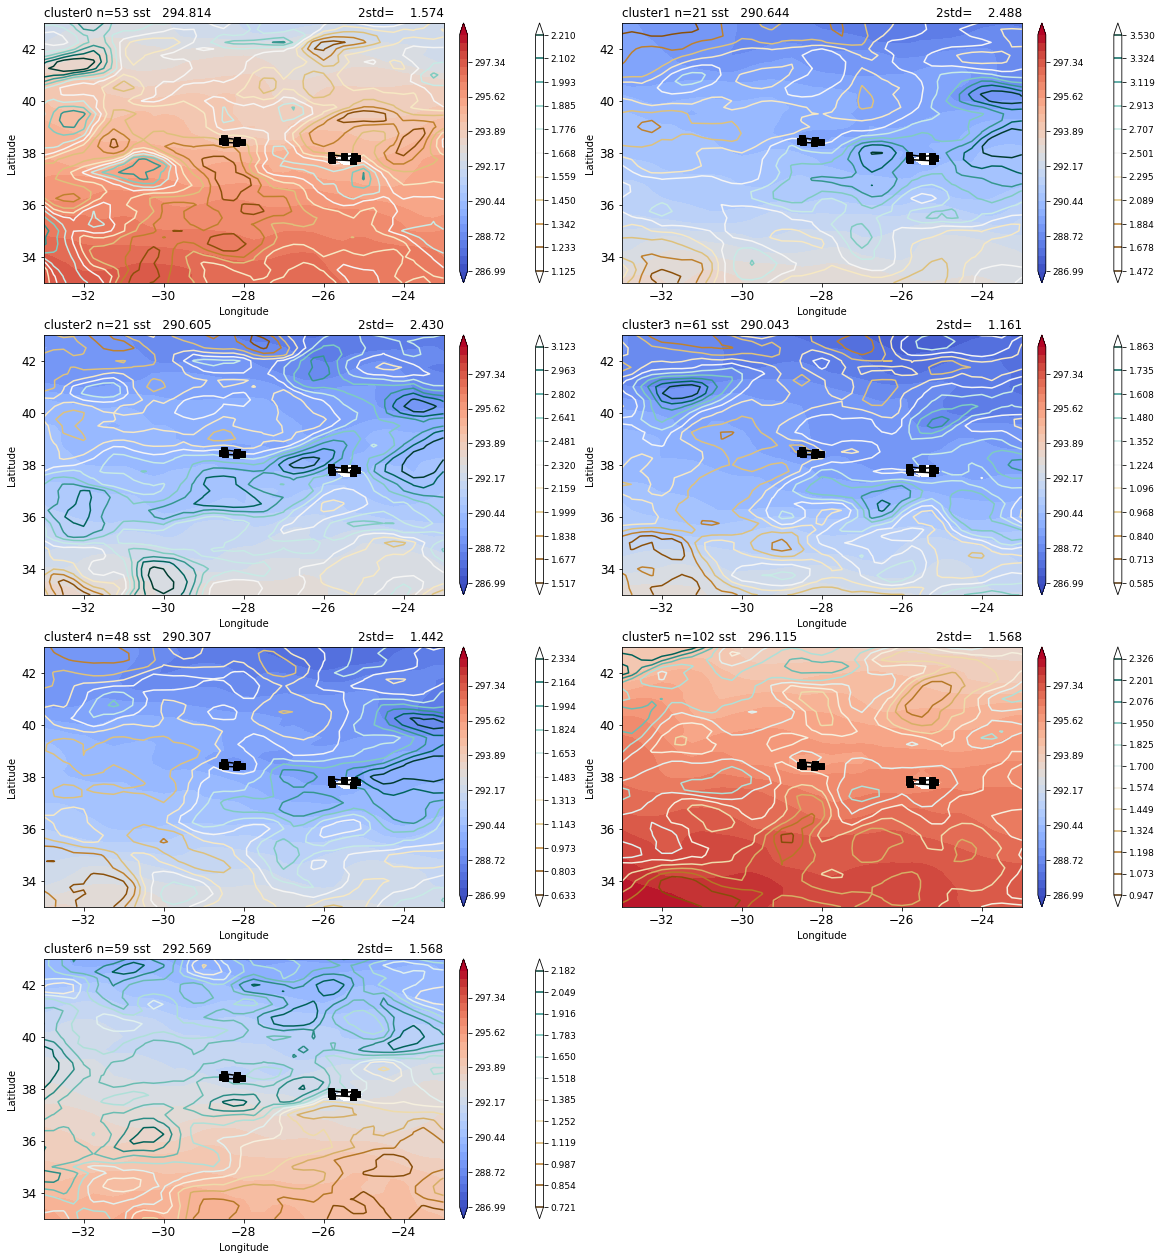

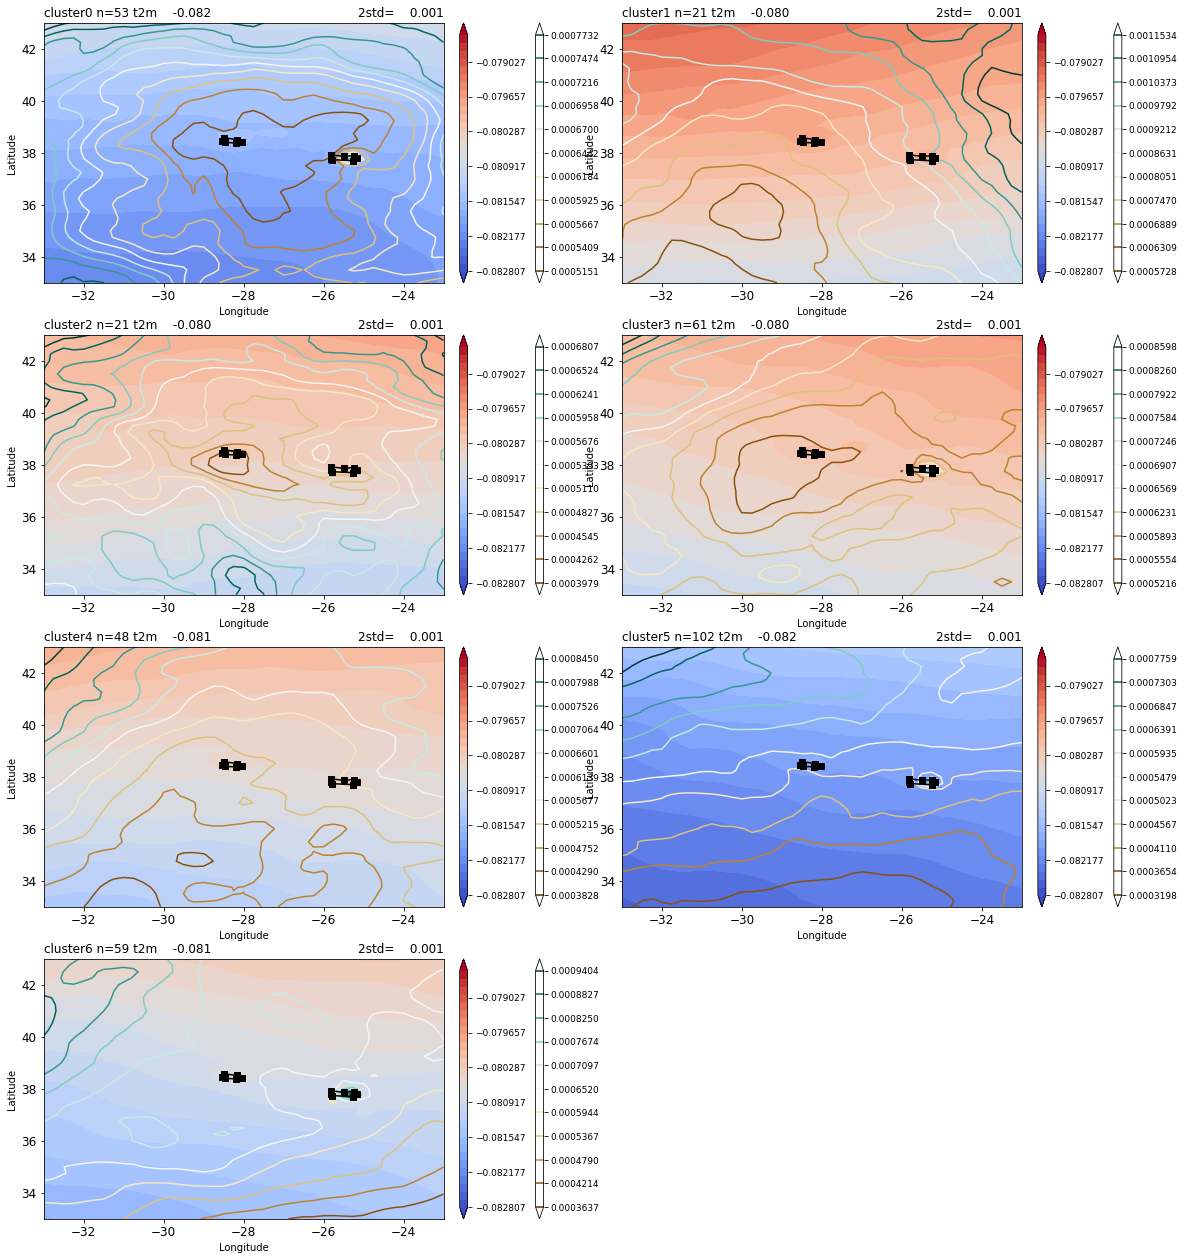

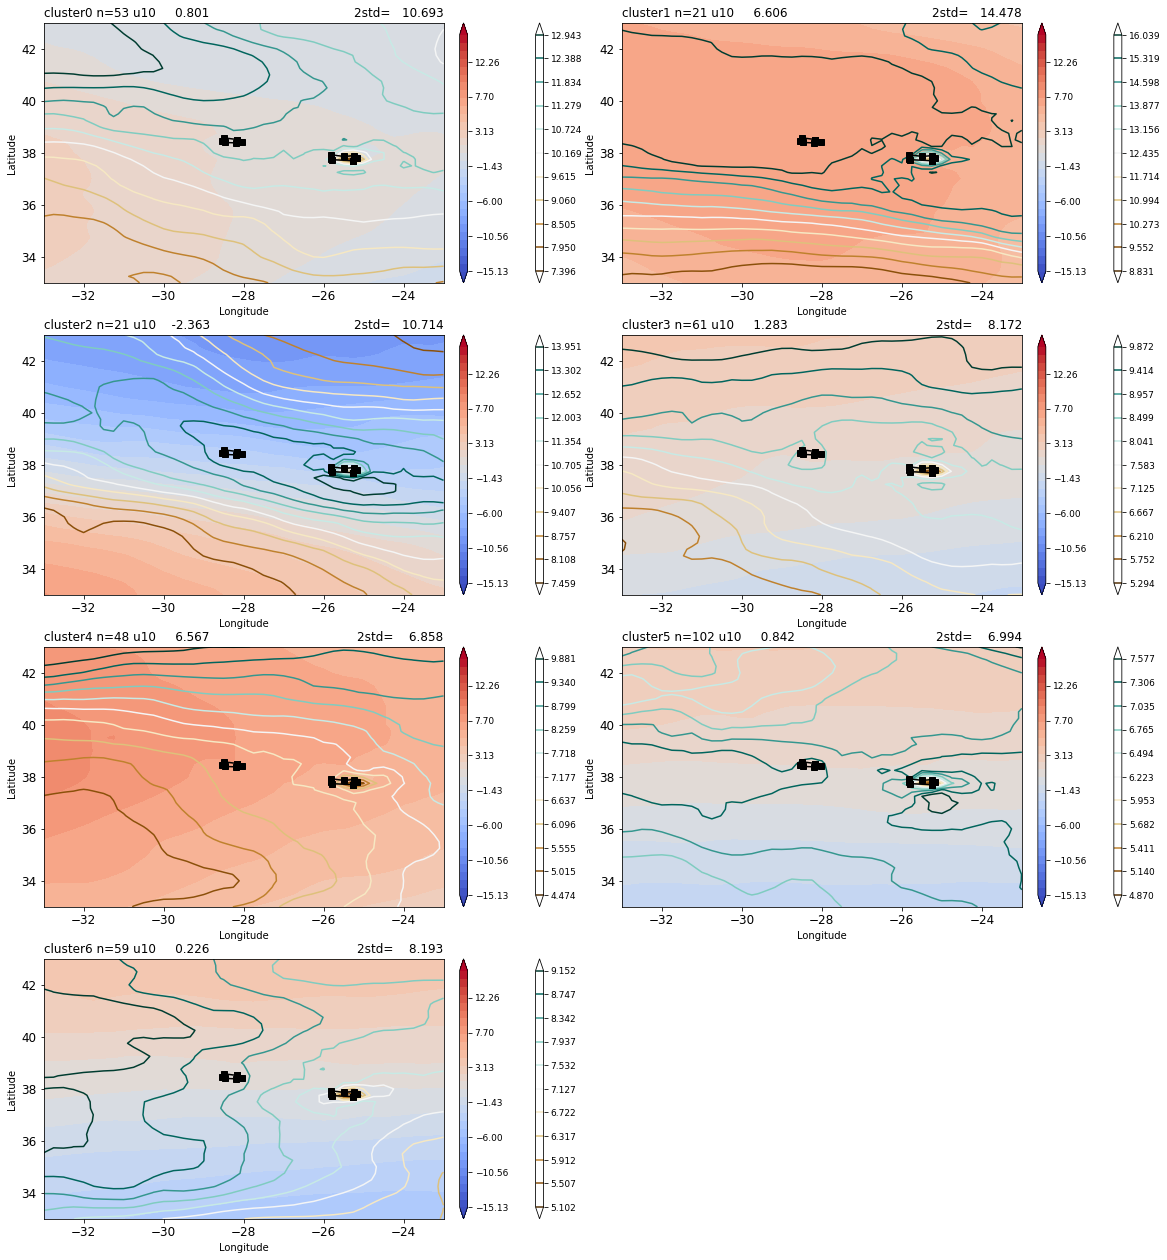

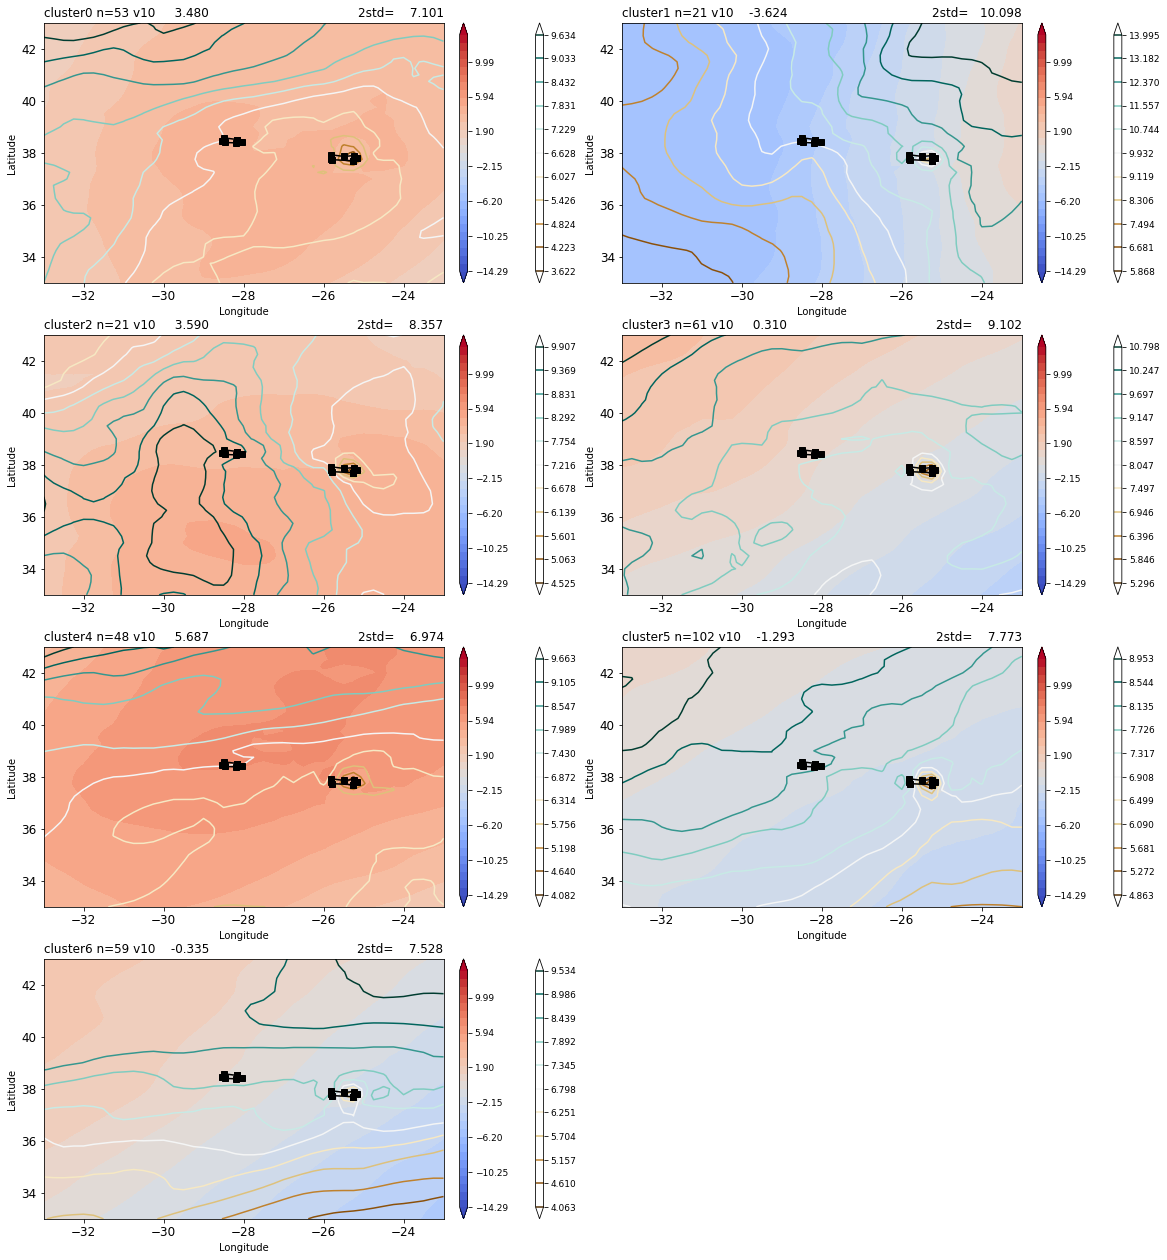

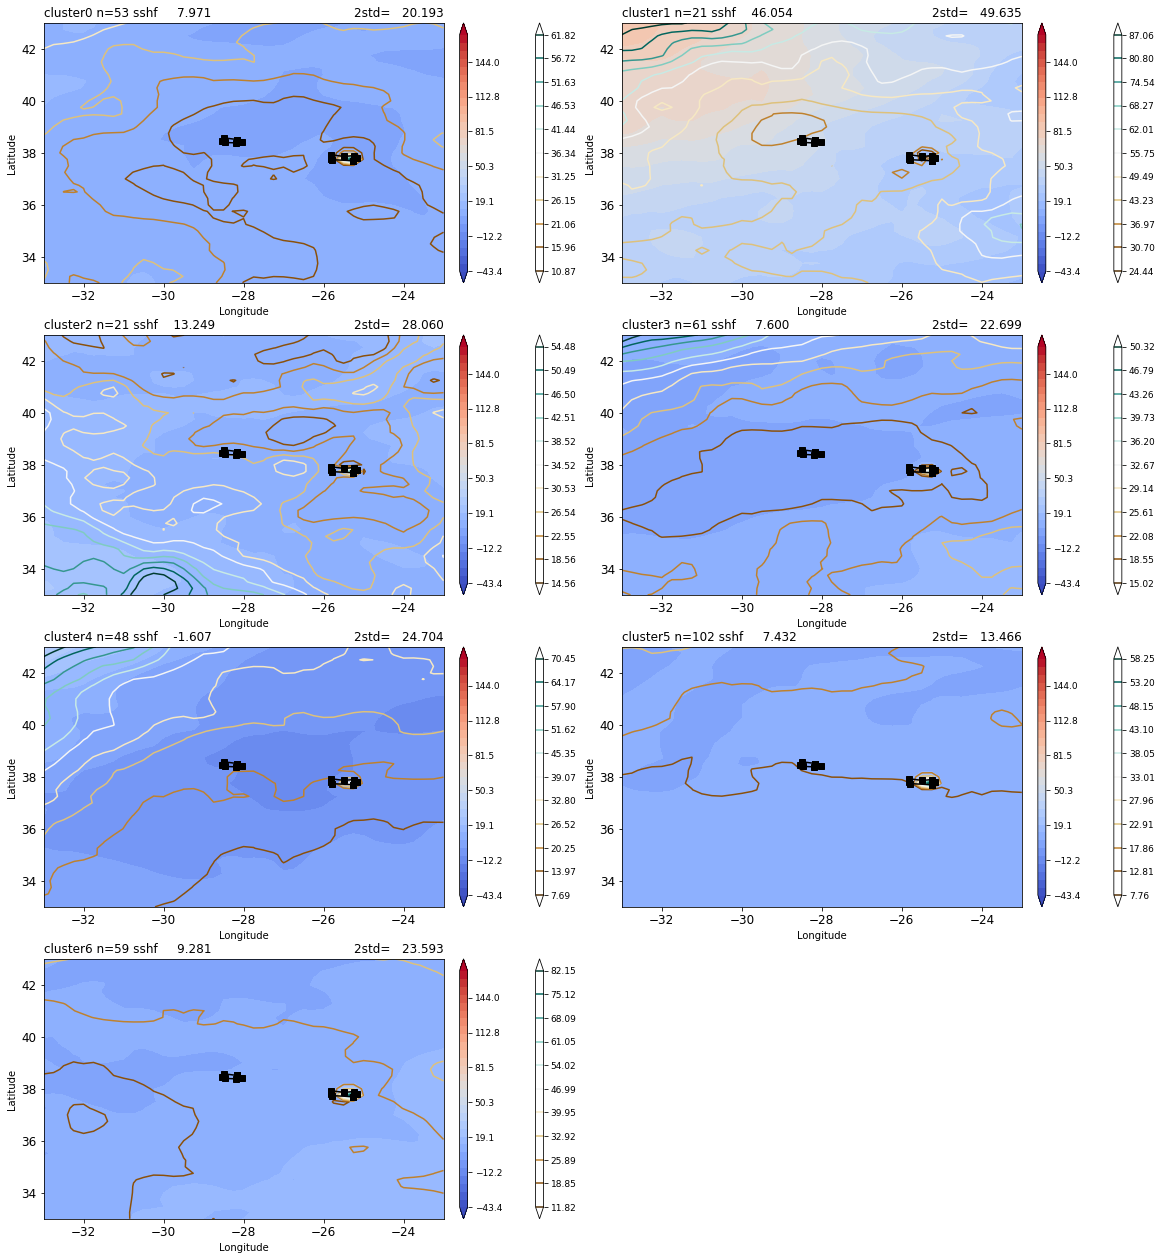

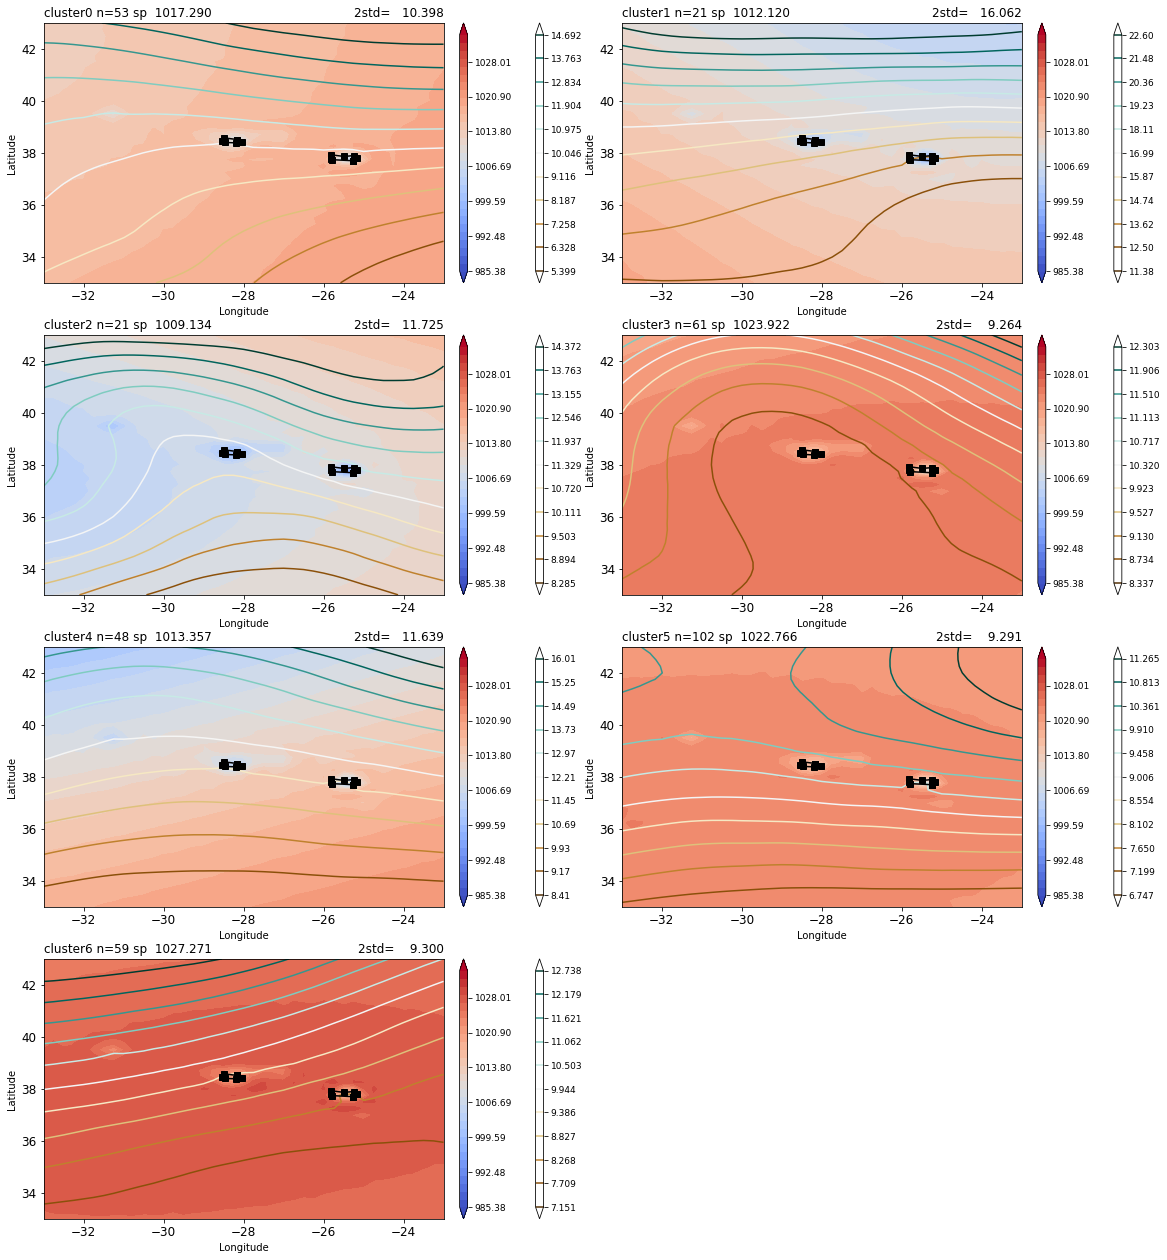

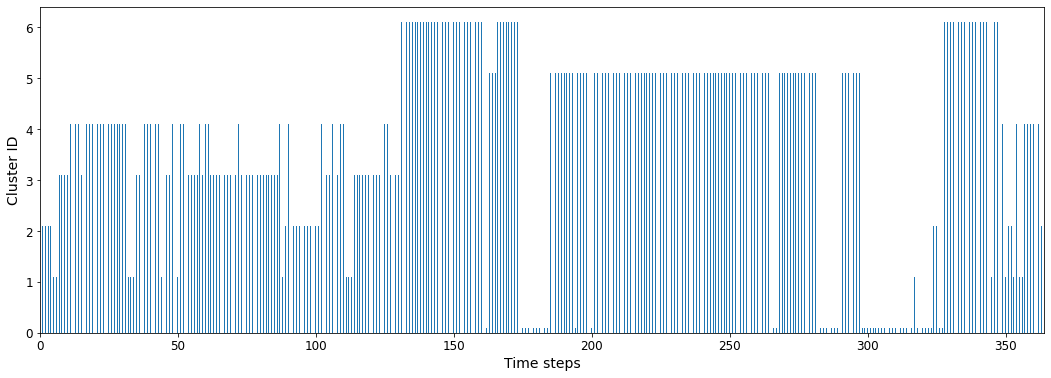

In [18]:
vis.visualization('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc' ,'/content/drive/MyDrive/my-cnn-result_0.28.csv', './coast.txt')

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In this function I have used previously trained model weights to predict the clustering results.

In [ ]:
def main_test():
    # setting the hyper parameters

    batch_size = 256
    maxiter = 2e4
    update_interval = 50
    tol = 0.0000001
    save_dir = '/content/drive/MyDrive/My_CNN_result_2'

    # load dataset
    x = data_clustering
    y = None
    n_clusters = 7

    #init = 'glorot_uniform'
    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

    # prepare the DEC model
    cnnmodel = CNNModel(dims=(41,41,7), n_clusters=n_clusters, init=init)

    cnnmodel.model.summary()
    cnnmodel.load_weights('/content/drive/MyDrive/My_CNN_result_2/sc_0.28_CNN_model_final.h5')
    t0 = time()
    y_pred = cnnmodel.predict(x)
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
val_res = main_test()
val_res